In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#import fasttext
import codecs
from tqdm import tqdm

In [2]:
train = pd.read_csv('data/hateval2019_en_train.csv')
test = pd.read_csv('data/hateval2019_en_test.csv')
val = pd.read_csv('data/hateval2019_en_test.csv')

train = train.drop(['TR','AG'],1)
test = test.drop(['TR','AG'],1)
val = val.drop(['TR','AG'],1)

/tmp/ipykernel_11506/157768247.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train = train.drop(['TR','AG'],1)
/tmp/ipykernel_11506/157768247.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test = test.drop(['TR','AG'],1)
/tmp/ipykernel_11506/157768247.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  val = val.drop(['TR','AG'],1)


<AxesSubplot:xlabel='HS', ylabel='count'>

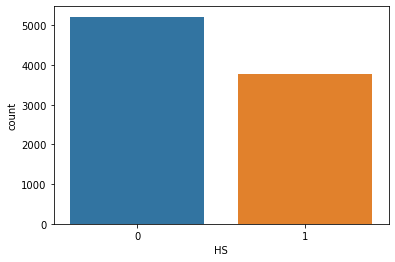

In [3]:
sns.countplot(data=train,x='HS')

Unbalanced but not massively

Fasttext model. tokenizer->fast text embedding ->LSTM->Linear->linear->sigmoid

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import io

In [6]:
def x_y_split(data):
    """splits and X and y from dataframe

    Args:
        data:dataframe to split from

    Returns:
        tuple:X data, y data
    """
    X = data['text']
    y = data['HS']
    return X, y

In [7]:
#Split x and ys
x_train, y_train = x_y_split(train)

In [8]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(x_train)
def tokenize_and_pad(x_data,tokenizer=tokenizer,length=57):
    """
    Tokenizes and pads input
    :param x_data: X column of data
    :param tokenizer: fitted tokenizer
    :param length: length to pad
    :return: tokenized and padded x_data
    """
    x_data = tokenizer.texts_to_sequences(x_data)
    x_data = pad_sequences(x_data,maxlen=length)
    return x_data
x_train = tokenize_and_pad(x_train,tokenizer)
def split_and_tokenize(data,tokenizer=tokenizer):
    """
    Splits tokenizes and pads data
    :param data:
    :return: tupple of (X,y)
    """
    X, y = x_y_split(data)
    X = tokenize_and_pad(X)
    return X, y

In [9]:
x_val , y_val = split_and_tokenize(val)
x_test, y_test = split_and_tokenize(test)

In [20]:
embed_dim = 300
lstm_out = 196
input_length=x_train.shape[1]

In [21]:
#https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('data/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))



loading word embeddings...


999995it [00:39, 25127.98it/s]

found 999995 word vectors


In [22]:
#embedding matrix
nb_words = min(max_features, len(tokenizer.word_index))
words_not_found = []
embedding_matrix = np.zeros((nb_words,embed_dim))
word_index = tokenizer.word_index
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 571


570

In [23]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ["immigrant's" 'hasn’t' 'kakuma' 'trudeau' 'rapefugees' 'judgejeanine'
 'keepfamiliestogether' '“i' "where's" 'nochainmigration']


In [24]:
model = Sequential()
model.add(Embedding(max_features,embed_dim,input_length=input_length, weights=[embedding_matrix],trainable=False))
model.add(LSTM(lstm_out))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss=BinaryCrossentropy(),optimizer='adam',metrics=['accuracy'])
print(model.summary())

2022-03-14 22:29:14.015927: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-14 22:29:14.017571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-14 22:29:14.090244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 22:29:14.090678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.77GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-14 22:29:14.090701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-14 22:29:14.097021: I tensorflow/stream_executor/platfo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 57, 300)           1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 196)               389648    
_________________________________________________________________
dense (Dense)                (None, 128)               25216     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,931,505
Trainable params: 431,505
Non-trainable params: 1,500,000
_________________________________________________________________
None


In [25]:
filepath = 'checkpoints/test.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 monitor='val_loss',
                                                save_best_only=True,
                                                 verbose=1,
                                                mode='min')
callbacks = [checkpoint]

history = model.fit(x=x_train,
                    y=y_train,batch_size=32,
                    validation_data=(x_val,y_val),
                    epochs=5,
                    callbacks=callbacks)

2022-03-14 22:29:17.229599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-14 22:29:17.266280: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3393690000 Hz


Epoch 1/5


2022-03-14 22:29:21.209422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-14 22:29:21.776391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


282/282 [==============================] - 8s 7ms/step - loss: 0.5856 - accuracy: 0.6827 - val_loss: 0.9106 - val_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 0.91061, saving model to checkpoints/test.hdf5
Epoch 2/5
282/282 [==============================] - 1s 5ms/step - loss: 0.5016 - accuracy: 0.7487 - val_loss: 0.9864 - val_accuracy: 0.4820

Epoch 00002: val_loss did not improve from 0.91061
Epoch 3/5
282/282 [==============================] - 2s 6ms/step - loss: 0.4658 - accuracy: 0.7745 - val_loss: 0.9078 - val_accuracy: 0.5357

Epoch 00003: val_loss improved from 0.91061 to 0.90781, saving model to checkpoints/test.hdf5
Epoch 4/5
282/282 [==============================] - 1s 5ms/step - loss: 0.4514 - accuracy: 0.7815 - val_loss: 1.3779 - val_accuracy: 0.4913

Epoch 00004: val_loss did not improve from 0.90781
Epoch 5/5
282/282 [==============================] - 1s 5ms/step - loss: 0.4126 - accuracy: 0.8132 - val_loss: 1.6120 - val_accuracy: 0.4857

Epoch 00005: v

In [26]:
def plot_accuracy_loss_chart(history,epoch_count):
    """
    Plots accuracy and losses for each epoch
    :param history: history from fitting model
    :param epoch_count: amount of epochs to plot
    :return: None
    """
    epochs = [i for i in range(epoch_count)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

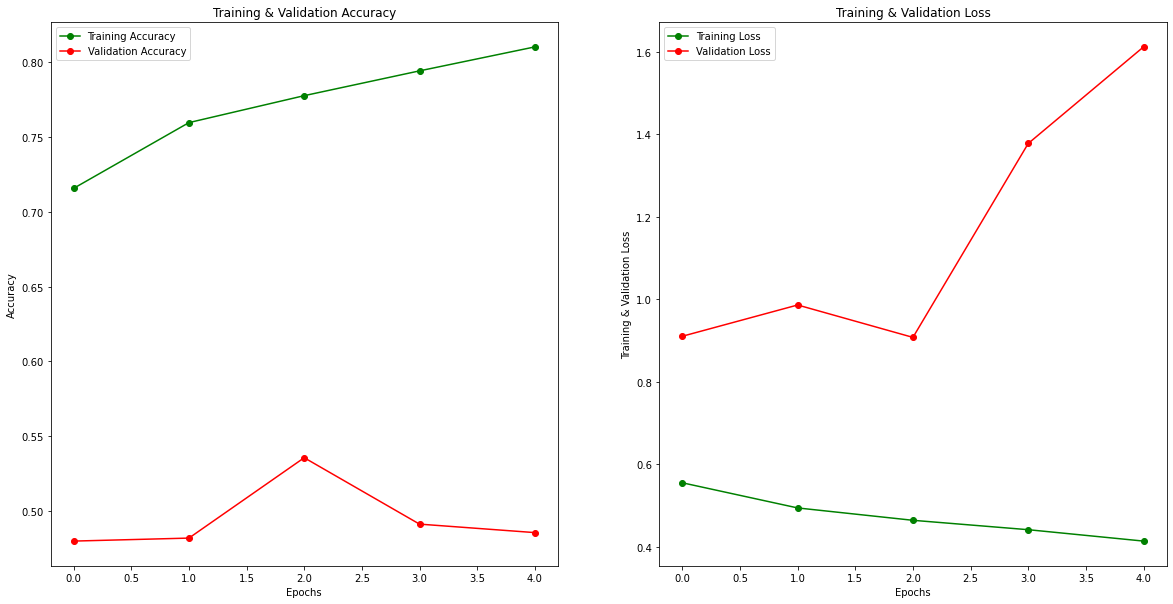

In [27]:
plot_accuracy_loss_chart(history,5)